## NEW


## 프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜보자.



평가문항
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.	공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.


2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.	구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.


3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.	한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.



## Step 1. 데이터 수집하기
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용.

이 데이터는 아래의 링크에서 다운로드할 수 있다.

songys/Chatbot_data

$ mkdir -p ~/aiffel/EXPLORATION/15/transformer_chatbot/data/

$ ln -s ~/data/* ~/aiffel/EXPLORATION/15/transformer_chatbot/data/

라이브러리 불러오기

In [25]:
import os
import re
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [40]:
dataset_file_path = os.getenv('HOME') + '/aiffel/EXP_15_transformer_chatbot/data/ChatbotData.csv'
dataset_file_path


'/aiffel/aiffel/EXP_15_transformer_chatbot/data/ChatbotData.csv'

## Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있다.

In [35]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 영어 포함 시 소문자 변환, 양쪽 공백 제거
    sentence = sentence.lower().strip()
    
    # 단어와 구두점 사이 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 알파벳, .,?!을 제외한 문자 공백으로 대체
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [36]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수

def load_conversations():
    with open(dataset_file_path, errors='ignore') as file:
        lines = file.readlines()
        
    inputs, outputs = [], []
    with open(dataset_file_path) as file:
        lines = csv.reader(file)
        next(lines)
        for line in lines:
            inputs.append(preprocess_sentence(line[0]))
            outputs.append(preprocess_sentence(line[1]))
    return inputs, outputs

In [41]:
questions, answers = load_conversations()

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))
print()
print('전처리 후의 11번째 질문 샘플: {}'.format(questions[11]))
print('전처리 후의 11번째 답변 샘플: {}'.format(answers[11]))

전체 샘플 수 : 11823
전체 샘플 수 : 11823

전처리 후의 11번째 질문 샘플: 가끔 궁금해
전처리 후의 11번째 답변 샘플: 그 사람도 그럴 거예요 .


## Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용.

토크나이징 단어장(Vocabulary) 만들기 - SubwordTextEncoder 이용


In [42]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [43]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8133]
END_TOKEN의 번호 : [8134]


In [44]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8135


In [45]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.9391017508246637
answers 최대 길이 : 24
answers 평균 길이 : 4.716146494121627


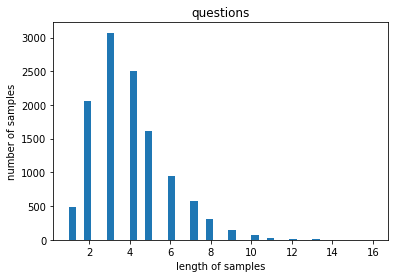

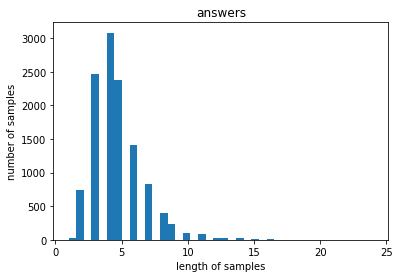

In [46]:
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [47]:
# 최대 허용 길이 지정
MAX_LENGTH = 10

# 정수인코딩, 최대길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작, 종료 토큰 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 10 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이 10으로 모든 데이터셋 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs

In [48]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8135
필터링 후의 질문 샘플 개수: 9128
필터링 후의 답변 샘플 개수: 9128


### 교사강요 (Teaching Force) 사용하기

In [49]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [50]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 10), dec_inputs: (None, 9)}, {outputs: (None, 9)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현.

In [51]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

#### Scaled Dot Product Attention

내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구함

In [52]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)  # # tf.matmul : 두 텐서를 행렬곱한 결과 텐서를 리턴

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

#### Multi Head Attention

내부적으로는 스케일드 닷 프로덕트 어테션 함수를 호출

In [53]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

#### Masking

특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

Padding Masking

문자의 길이를 맞추기 위해서 패딩을 넣어 처리해준 부분은 실제 의미가 있는 단어가 아니므로 패딩부분을 마스킹하여 가려준다.

In [54]:
# 0인 위치에서 숫자 1이 나오고, 숫자0이 아닌 위치는 숫자0이 나오게 하는 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

#### Look-ahead Masking 다음 단어 가리기

RNN은 각 step마다 순서대로 들어가는 반면, 트랜스포머는 문장행렬을 만들어 한 번에 행렬형태로 입력으로 들어가기 때문에 마스킹을 한다.

In [55]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

#### 인코더

하나의 인코더 층은 2개의 서브 층으로 나뉜다.


셀프어텐션(멀티 헤드 어텐션)


피드 포워드 신경망

In [56]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
    })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [57]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 디코더

셀프 어텐션
인코더-디코더 어텐션 : query가 디코더의 벡터, key-value가 인코더의 벡터
피드 포워드 신경망

In [58]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

In [59]:
# 디코더 층을 쌓아 디코더 만들기
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name
    )

## 모델 정의 및 훈련

In [60]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='enc_padding_mask'
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask'
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape=(1, 1, None),
        name='dec_padding_mask'
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 모델생성

In [61]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 5 # 인코더와 디코더의 층의 개수
D_MODEL = 512  # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512    # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1  # 드롭아웃 비율


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    12055040    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 손실함수

레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [62]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 커스텀된 학습률 learning rate

In [63]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

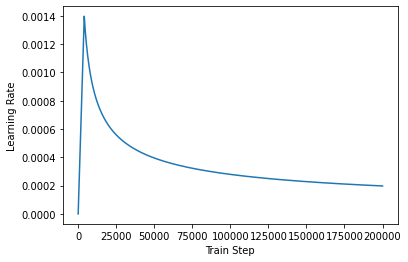

In [64]:
# 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 모델 컴파일

In [65]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [67]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
143/143 [==============================] - 296s 2s/step - loss: 3.0865 - accuracy: 0.2440
Epoch 2/20
143/143 [==============================] - 301s 2s/step - loss: 2.8825 - accuracy: 0.2599
Epoch 3/20
143/143 [==============================] - 291s 2s/step - loss: 2.6481 - accuracy: 0.2814
Epoch 4/20
143/143 [==============================] - 293s 2s/step - loss: 2.3832 - accuracy: 0.3106
Epoch 5/20
143/143 [==============================] - 295s 2s/step - loss: 2.1010 - accuracy: 0.3419
Epoch 6/20
143/143 [==============================] - 289s 2s/step - loss: 1.8172 - accuracy: 0.3769
Epoch 7/20
143/143 [==============================] - 299s 2s/step - loss: 1.5417 - accuracy: 0.4148
Epoch 8/20
143/143 [==============================] - 289s 2s/step - loss: 1.2852 - accuracy: 0.4511
Epoch 9/20
143/143 [==============================] - 288s 2s/step - loss: 1.0479 - accuracy: 0.4863
Epoch 10/20
143/143 [==============================] - 299s 2s/step - loss: 0.8409 - accura

## Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [69]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [70]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [71]:
sentence_generation('출근해야돼')

입력 : 출근해야돼
출력 : 잠시 쉬어도 돼요 .


'잠시 쉬어도 돼요 .'

In [72]:
sentence_generation('이 커진 마음을 어떻게 전할까?')

입력 : 이 커진 마음을 어떻게 전할까?
출력 : 모르는 게 잘못인 거 같아요 .


'모르는 게 잘못인 거 같아요 .'

In [73]:
sentence_generation('일하기 싫어 ㅠㅠ')

입력 : 일하기 싫어 ㅠㅠ
출력 : 부모님도 당사자도 가세요 .


'부모님도 당사자도 가세요 .'

In [74]:
sentence_generation('인생은 무엇일까?')

입력 : 인생은 무엇일까?
출력 : 직접 물어보세요 .


'직접 물어보세요 .'

In [75]:
sentence_generation('그 사람한테 고백할까?')

입력 : 그 사람한테 고백할까?
출력 : 당당하게 고 더 자주 만나세요 .


'당당하게 고 더 자주 만나세요 .'

In [76]:
sentence_generation('오늘 너무 지루했어')

입력 : 오늘 너무 지루했어
출력 : 서로에게 맞추는 과정이에요 .


'서로에게 맞추는 과정이에요 .'

In [77]:
sentence_generation('너는 뭘 먹는걸 좋아해?')

입력 : 너는 뭘 먹는걸 좋아해?
출력 : 직접 물어보는 게 좋을 것 같아요 .


'직접 물어보는 게 좋을 것 같아요 .'

In [78]:
sentence_generation('왜 그렇게 생각해?')

입력 : 왜 그렇게 생각해?
출력 : 인생은 항상 마음 먹은 대로 되지 않아요 .


'인생은 항상 마음 먹은 대로 되지 않아요 .'

In [79]:
sentence_generation('너무 슬퍼')

입력 : 너무 슬퍼
출력 : 이제 같은 실수 안 하면 돼요 .


'이제 같은 실수 안 하면 돼요 .'

In [80]:
sentence_generation('내일 출근해야 하는데 어떻게 옷을 입을까?')

입력 : 내일 출근해야 하는데 어떻게 옷을 입을까?
출력 : 그 사람의 너무 되는게 많지 않죠 .


'그 사람의 너무 되는게 많지 않죠 .'

In [84]:
sentence_generation('오늘도 포장마차로 가네요')

입력 : 오늘도 포장마차로 가네요
출력 : 저랑 한잔 해요 .


'저랑 한잔 해요 .'

In [85]:
sentence_generation('헤어진 그녀가 보고싶네요')

입력 : 헤어진 그녀가 보고싶네요
출력 : 인연인가 봐요 .


'인연인가 봐요 .'

In [86]:
sentence_generation('아 기분나빠')

입력 : 아 기분나빠
출력 : 말로 하는 상처는 지울 수도 없죠 .


'말로 하는 상처는 지울 수도 없죠 .'

In [87]:
sentence_generation('데이트 어디로 가야하지?')

입력 : 데이트 어디로 가야하지?
출력 : 저는 오래 살고 싶어요 .


'저는 오래 살고 싶어요 .'

In [88]:
sentence_generation('사랑해')

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [89]:
sentence_generation('썸 타는 남자가 있는데')

입력 : 썸 타는 남자가 있는데
출력 : 부럽네요 !


'부럽네요 !'

In [90]:
sentence_generation('비용이 많이 들어')

입력 : 비용이 많이 들어
출력 : 같이 내는 게 좋죠 .


'같이 내는 게 좋죠 .'

In [91]:
sentence_generation('더 알고 싶어')

입력 : 더 알고 싶어
출력 : 자세히 관찰해보세요 .


'자세히 관찰해보세요 .'

In [92]:
sentence_generation('늦은 시간')

입력 : 늦은 시간
출력 : 길지 않길 바랄게요 .


'길지 않길 바랄게요 .'

In [93]:
sentence_generation('귀여워')

입력 : 귀여워
출력 : 사랑이 모두 정답몰라요 .


'사랑이 모두 정답몰라요 .'

In [96]:
sentence_generation('부모님을 뵈러가자')

입력 : 부모님을 뵈러가자
출력 : 좋은 채워질 거예요 .


'좋은 채워질 거예요 .'

In [97]:
sentence_generation('졸려')

입력 : 졸려
출력 : 낮잠을 잠깐 자도 괜찮아요 .


'낮잠을 잠깐 자도 괜찮아요 .'

In [98]:
sentence_generation('도와줘')

입력 : 도와줘
출력 : 도와드릴게요 .


'도와드릴게요 .'

In [99]:
sentence_generation('섭섭해')

입력 : 섭섭해
출력 : 한결 나아졌길 바랄게요 .


'한결 나아졌길 바랄게요 .'

In [100]:
sentence_generation('자소서를 어떻게 써야되요?')

입력 : 자소서를 어떻게 써야되요?
출력 : 한푼 두푼 차곡차곡


'한푼 두푼 차곡차곡'

In [102]:
sentence_generation('아이씨 짜증나')

입력 : 아이씨 짜증나
출력 : 좋겠어요 .


'좋겠어요 .'

In [103]:
sentence_generation('약올리니?')

입력 : 약올리니?
출력 : 그냥 좋아하면 돼요 .


'그냥 좋아하면 돼요 .'

In [104]:
sentence_generation('꿈을 어떻게 찾아야되요?')

입력 : 꿈을 어떻게 찾아야되요?
출력 : 이별의 이유가 있을 테니까요 .


'이별의 이유가 있을 테니까요 .'

## 회고

챗봇은 내가 꼭 만들어 보고 싶었던 인공지능이다. 나는 아직도 이루다의 충격을 잊지 못한다. 사람에게 공감하는 '척'을 하는 챗봇이었지만 '강아지'가 사람이랑 대화하지 못한다고 해도 어느정도의 감정교류나 애정을 공유할 수 있다는 점에서 의미있듯이 챗봇은 인간에게 있어서 외로움이나 정신적인 지지를 도와줄 수 있을거라고 확신한다.

처음에 모델을 학습시키다 실수로 LMS에서 "학습환경 변경"을 눌러서 반나절 이상을 걸려서 만들은 17개의 epoch이 날아갔다... 굉장히 분노가 치밀어 올랐지만...? 이 모든것은 조심하지 않은 나의 잘못... 다음에는 꼭 callbacks를 활용해 모델을 5 epoch 마다 저장해 사용할 것이다.


데이터 전처리 과정을 진행하였고, 시간이 너무 오래 걸리기에 epoch을 줄여서 진행하였다 (100 --> 20).


질문에 따라서 자연스러운 답변을 주기도 했고, 이상한 답변을 주는 경우도 있었다.


#### 좋은 예시

 - 입력 : 너무 슬퍼
 - 출력 : 이제 같은 실수 안 하면 돼요 .
 
 위와 같은 입력 출력은 정말 완벽한 위로를 제공하지만


#### 나쁜 예시


 - 입력 : 일하기 싫어 ㅠㅠ
 - 출력 : 부모님도 당사자도 가세요 .
 
 이 케이스 같은 경우에는 문맥을 전혀 이해하지 못했다고 볼 수 있다. 이는 분명 대화데이터셋에서 자연스러운 데이터를 넣어주지 못했기 때문일 것 같다.
 


#### 학습 문장을 그대로 출력하는거 같다

e.g. 

 - 입력 : 오늘도 포장마차로 가네요
 - 출력 : 저랑 한잔 해요 .

위의 입력/출력은 "오늘도 포장마차,저랑 한잔 해요.,1" 데이터로 만들어진 답변이 분명하다.

이러한 점을 보완하기 위해 Going Deeper과정에서 데이터를 더 많이 찾아와서 더욱 더 정교한 챗봇을 만들어 페르소나를 가진 나만의 친구챗봇을 만들고 싶다.